# Faster R-CNN базовая модель

# Импорт библиотек

In [1]:
!pip install -q kagglehub tqdm
!pip install torchmetrics
!pip install -U gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.3 MB/s eta 0:00:00


In [2]:
import os
import json
import random
from collections import Counter

import yaml
import kagglehub
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import deform_conv2d

from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
    FasterRCNN
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision
import matplotlib.pyplot as plt

import gdown

import math


# Загрузка датасета

Используемый датасет предоставлен в формате YOLOv11

In [3]:
path = kagglehub.dataset_download("romankornyushenkov/neu-det-v5")
print("Path to dataset files:", path)

yaml_path = os.path.join(path, "data.yaml")
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Классы:", data_config['names'])
print("Число классов:", len(data_config['names']))

Using Colab cache for faster access to the 'neu-det-v5' dataset.
Path to dataset files: /kaggle/input/neu-det-v5
Классы: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
Число классов: 6


Перевод датасета в нужный формат

In [4]:
def yolo_to_bbox(yolo_line, img_width, img_height):
    parts = yolo_line.strip().split()
    class_id = int(parts[0]) + 1
    x_center = float(parts[1]) * img_width
    y_center = float(parts[2]) * img_height
    box_w = float(parts[3]) * img_width
    box_h = float(parts[4]) * img_height

    x1 = max(0, x_center - box_w / 2)
    y1 = max(0, y_center - box_h / 2)
    x2 = min(img_width, x_center + box_w / 2)
    y2 = min(img_height, y_center + box_h / 2)
    return [x1, y1, x2, y2], class_id

class MetalDefectDatasetCached(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, cache_images=True):
        self.img_dir = img_dir
        self.imgs = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.transform = transforms.ToTensor()
        self.cache_images = cache_images

        print(f"Кэшируем аннотации для {len(self.imgs)} изображений..")
        self.cached_annotations = []
        self.cached_images = [] if cache_images else None

        for img_name in tqdm(self.imgs, desc="Подготовка данных"):
            img_path = os.path.join(img_dir, img_name)
            img_pil = Image.open(img_path).convert("RGB")
            img_width, img_height = img_pil.size

            if cache_images:
                self.cached_images.append(self.transform(img_pil))

            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
            boxes, labels = [], []
            if os.path.exists(label_path):
                with open(label_path) as f:
                    for line in f:
                        if line.strip():
                            bbox, label = yolo_to_bbox(line, img_width, img_height)
                            boxes.append(bbox)
                            labels.append(label)

            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4))
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
            self.cached_annotations.append({'boxes': boxes_tensor, 'labels': labels_tensor})

            if not cache_images:
                img_pil.close()

        print(f" Данные подготовлены. Кэширование изображений: {cache_images}")

    def __getitem__(self, idx):
        if self.cache_images:
            img = self.cached_images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.imgs[idx])
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)

        return img, self.cached_annotations[idx]

    def __len__(self):
        return len(self.imgs)


In [5]:
train_img_dir = os.path.join(path, "train", "images")
train_label_dir = os.path.join(path, "train", "labels")
val_img_dir = os.path.join(path, "valid", "images")
val_label_dir = os.path.join(path, "valid", "labels")
test_img_dir = os.path.join(path, "test", "images")
test_label_dir = os.path.join(path, "test", "labels")

In [6]:
train_dataset = MetalDefectDatasetCached(train_img_dir, train_label_dir)
val_dataset = MetalDefectDatasetCached(val_img_dir, val_label_dir)
test_dataset = MetalDefectDatasetCached(test_img_dir, test_label_dir)

Кэшируем аннотации для 1260 изображений..


Подготовка данных: 100%|██████████| 1260/1260 [00:10<00:00, 120.32it/s]


 Данные подготовлены. Кэширование изображений: True
Кэшируем аннотации для 359 изображений..


Подготовка данных: 100%|██████████| 359/359 [00:02<00:00, 132.98it/s]


 Данные подготовлены. Кэширование изображений: True
Кэшируем аннотации для 180 изображений..


Подготовка данных: 100%|██████████| 180/180 [00:01<00:00, 130.56it/s]

 Данные подготовлены. Кэширование изображений: True


In [7]:
# Объединяем train и valid
full_train_dataset = ConcatDataset([train_dataset, val_dataset])

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

full_train_dataloader = DataLoader(
    full_train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

## Пример тренировочных данных

/usr/local/lib/python3.12/dist-packages/torchvision/utils.py:375: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


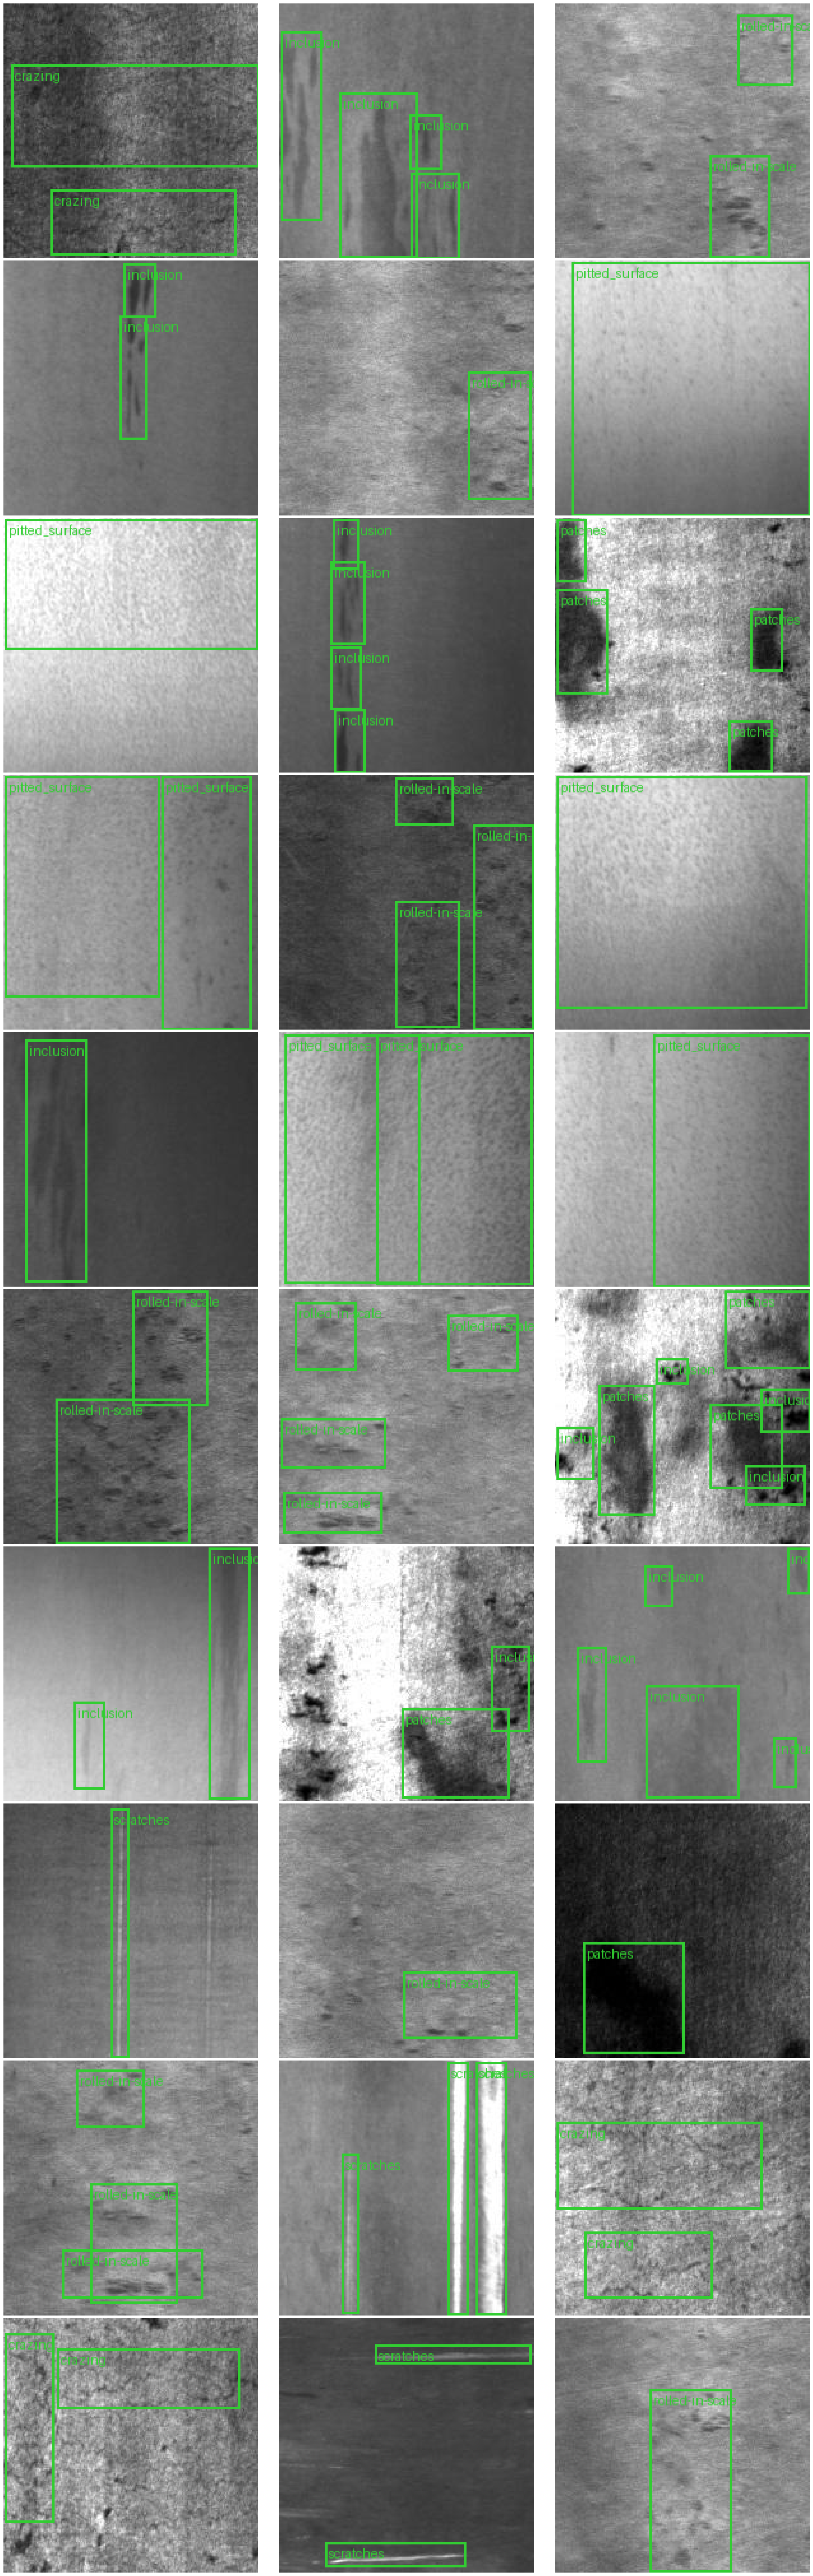

In [9]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
indices = random.sample(range(len(full_train_dataset)), k=30)

fig, axes = plt.subplots(10, 3, figsize=(25, 75))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img, target = full_train_dataset[idx]
    img_uint8 = (img * 255).to(torch.uint8)

    boxes = target['boxes']
    labels = target['labels']

    if len(labels) > 0:
        label_names = [class_names[lb.item() - 1] for lb in labels]
    else:
        label_names = []

    img_with_boxes = draw_bounding_boxes(
        image=img_uint8,
        boxes=boxes,
        labels=label_names,
        colors='limegreen',
        width=2,
        font_size=12
    )

    axes[i].imshow(img_with_boxes.permute(1, 2, 0))
    axes[i].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Создание модели

## Загрузка базовой модели

In [21]:
model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    trainable_backbone_layers=5
)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)

In [22]:
model.eval()
with torch.no_grad():
    dummy_input = [torch.randn(3, 640, 640)]
    output = model(dummy_input)
print("Forward pass успешен")

Forward pass успешен


# Обучение модели

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)


In [27]:
num_epochs = 50 #поставить необходимое количество

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    model.train()
    total_loss = 0

    progress_bar = tqdm(full_train_dataloader, desc="Training", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):

        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        progress_bar.set_postfix({
            'batch_loss': f"{losses.item():.4f}",
            'avg_loss': f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_train_loss = total_loss / len(full_train_dataloader)

    lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"LR: {current_lr:.6f}")


 Epoch 1/50


KeyboardInterrupt: 

## Полный чекпонит после обучения

Сохраняем полный чекпоинт для возможности продолжения обучения модели начиная с последней эпохи

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
}, f"faster_rcnn_neu_det_v5_baseline_EP_{epoch}.pth") #сохранение локально, поменять путь при сохранении на Google Disk
print(f"Файл сохранен как: faster_rcnn_neu_det_v5_baseline_EP_{epoch}.pth")

Файл сохранен как: faster_rcnn_neu_det_v5_baseline_EP_0.pth


# Загрузка чекпоинта и тестирование модели

Создаем новый экземпляр модели

In [31]:
model_test = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    trainable_backbone_layers=5
)
in_features = model_test.roi_heads.box_predictor.cls_score.in_features
model_test.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_test.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Загружаем лучший чекпоинт для тестирования

In [34]:
file_id = "1CuH8EAVQivotfuSaNA8IpbHDsEJWLfCu"
output_filename = "faster_rcnn_neu_det_v5_baseline_best_EP_51.pth"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_filename, quiet=False, fuzzy=True)

checkpoint_path = output_filename
#checkpoint_path = "/content/drive/MyDrive/Datasets/faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74" #При скачивании со своего Google Disk
#checkpoint_path = "faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74" #При локальном расположении файла чекпоинта
print(f"Файл скачан: {checkpoint_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1CuH8EAVQivotfuSaNA8IpbHDsEJWLfCu
From (redirected): https://drive.google.com/uc?id=1CuH8EAVQivotfuSaNA8IpbHDsEJWLfCu&confirm=t&uuid=4e2b01c3-285f-4101-9260-36b2c67fcef4
To: /content/faster_rcnn_neu_det_v5_baseline_best_EP_51.pth
100%|██████████| 331M/331M [00:06<00:00, 47.8MB/s]

Файл скачан: faster_rcnn_neu_det_v5_baseline_best_EP_51.pth


In [19]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [35]:
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Тестирование модели при пороге IoU = 0.5

In [36]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_thresholds=[0.5],
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    metric.update(preds, target_list)

results = metric.compute()

print("Результат оценки:")
print(" ")
print(f"mAP@0.5:       {results['map_50']:.4f}")

prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:18<00:00,  9.58it/s]


Результат оценки:
 
mAP@0.5:       0.7690
Precision:     0.6170
Recall:        0.7600
F1:            0.6811
 
Метрики по классам (AP@0.5)
 
crazing           : 0.3166
inclusion         : 0.8587
patches           : 0.9529
pitted_surface    : 0.8824
rolled-in-scale   : 0.6197
scratches         : 0.9840


Тестирование модели при порогах IoU [0.5-0.95]

In [37]:
from torchmetrics.detection import MeanAveragePrecision
import torch
from pprint import pprint
from tqdm import tqdm

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

map_metric = MeanAveragePrecision(
    box_format='xyxy',
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    map_metric.update(preds, target_list)

results = map_metric.compute()

print("Результат оценки:")
print(" ")
#print(f"mAP@0.5:       {results['map_50']:.4f}")
print(f"mAP@0.5-0.95:  {results['map']:.4f}")


prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5-0.95)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:18<00:00,  9.84it/s]


Результат оценки:
 
mAP@0.5-0.95:  0.4127
Precision:     0.3381
Recall:        0.4433
F1:            0.3836
 
Метрики по классам (AP@0.5-0.95)
 
crazing           : 0.0889
inclusion         : 0.4595
patches           : 0.6129
pitted_surface    : 0.5111
rolled-in-scale   : 0.2592
scratches         : 0.5445


## Визуализация предсказаний модели

/usr/local/lib/python3.12/dist-packages/torchvision/utils.py:375: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


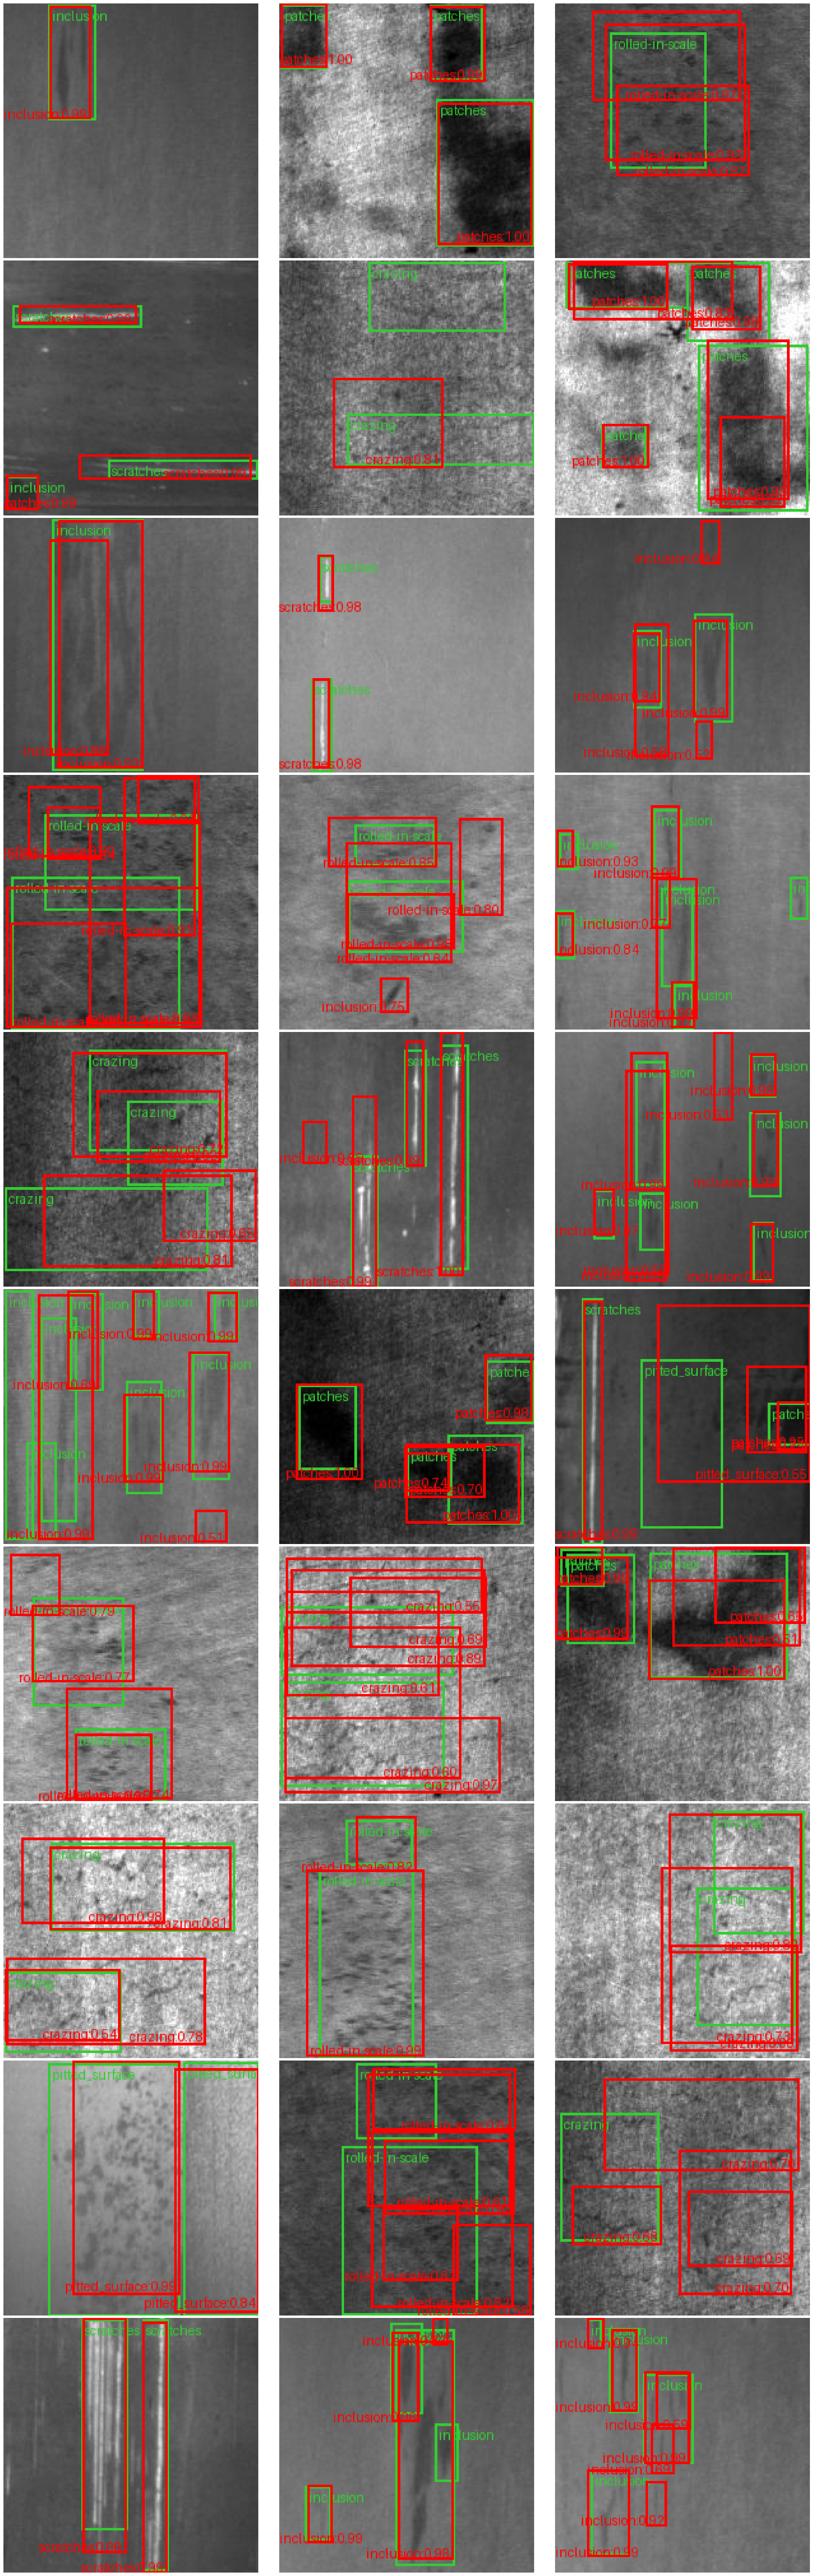

In [38]:
model_test.eval()

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

indices = random.sample(range(len(test_dataset)), k=30)

fig, axes = plt.subplots(10, 3, figsize=(25, 75))
axes = axes.flatten()

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, target = test_dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        model_output = model_test(img_tensor)[0]

        gt_boxes = target['boxes']
        gt_labels = target['labels']
        gt_label_names = [class_names[lb.item() - 1] for lb in gt_labels] if len(gt_labels) > 0 else []

        img_uint8 = (img * 255).to(torch.uint8)
        img_with_gt = draw_bounding_boxes(
            image=img_uint8,
            boxes=gt_boxes,
            labels=gt_label_names,
            colors='limegreen',
            width=2,
            font_size=14
        )

        pred_boxes = model_output['boxes']
        pred_scores = model_output['scores']
        pred_labels = model_output['labels']

        keep = pred_scores >= 0.5
        pred_boxes = pred_boxes[keep].cpu()
        pred_labels = pred_labels[keep].cpu()
        pred_scores = pred_scores[keep].cpu()

        img_pil = transforms.ToPILImage()(img_with_gt)
        draw = ImageDraw.Draw(img_pil)

        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 14)
        except:
            font = ImageFont.load_default()

        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = box.tolist()
            class_name = class_names[label.item() - 1]
            text = f"{class_name}:{score:.2f}"

            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            text_x = x2 - text_width - 2
            text_y = y2 - text_height - 2

            text_x = max(0, text_x)
            text_y = max(0, text_y)

            draw.text((text_x, text_y), text, fill='red', font=font)

        final_img = transforms.ToTensor()(img_pil)
        axes[i].imshow(final_img.permute(1, 2, 0))
        axes[i].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Продолжение обучения модели, используя чекпоинт

In [39]:
params = [p for p in model_test.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)

In [40]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [41]:
start_epoch = checkpoint['epoch']
start_epoch

54

In [ ]:
total_epochs = 100 #поставить необходимое количество

print(f"Загружено состояние после {start_epoch} эпох")
print(f"Продолжаем обучение с эпохи {start_epoch} до {total_epochs}")
print(f"Текущий LR: {optimizer.param_groups[0]['lr']:.8f}")

for epoch in range(start_epoch, total_epochs):
    print(f"\n Epoch {epoch+1}/{total_epochs}")

    model_test.train()
    total_loss = 0

    progress_bar = tqdm(full_train_dataloader, desc="Training", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model_test(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        progress_bar.set_postfix({
            'batch_loss': f"{losses.item():.4f}",
            'avg_loss': f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_train_loss = total_loss / len(full_train_dataloader)

    lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"LR: {current_lr:.6f}")

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model_test.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
}, f"faster_rcnn_neu_det_v5_baseline_EP_{epoch}.pth") #сохранение локально, поменять путь при сохранении на Google Disk
print(f"Файл сохранен как: faster_rcnn_neu_det_v5_baseline_EP_{epoch}.pth")